In [58]:
import tensorflow as tf

In [59]:
tf.__version__

'2.15.0'

In [60]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Using MNIST dataset for the model

In [61]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [62]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [63]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [64]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Defining the generator and the discrminator

In [65]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Using the generator to create an image.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_7 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_8 (Bat  (None, 7, 7, 128)        

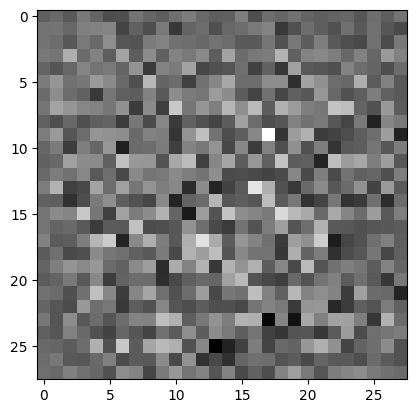

In [66]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
generator.summary()

Using CNN based discriminator

In [67]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [68]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
discriminator.summary()

tf.Tensor([[0.00122182]], shape=(1, 1), dtype=float32)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 128)         0         
                                                                 

Defining the loss functions and optimizers for both models

In [69]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [70]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [71]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [72]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Saving the checkpoints

In [73]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Defining the training loop and setting the hyperparameters


In [74]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Using random seed as input

In [75]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [76]:
def train(dataset, epochs):
  gen_losses = []
  disc_losses = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)

    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)

    #print(f'Epoch {epoch+1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')




    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

   # Plot the losses
  plt.figure(figsize=(10, 5))
  plt.plot(gen_losses, label='Generator Loss')
  plt.plot(disc_losses, label='Discriminator Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Generator and Discriminator Loss During Training')
  plt.show()

  # Print minimum errors observed
  print(f'Minimum Generator Loss: {min(gen_losses)}')
  print(f'Minimum Discriminator Loss: {min(disc_losses)}')

Generating and saving images


In [77]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Training and plotting the graph of the loss curves

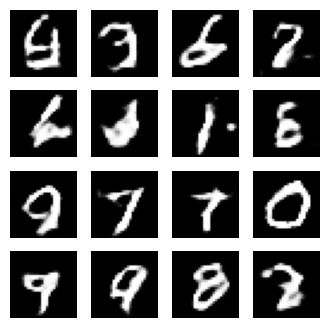

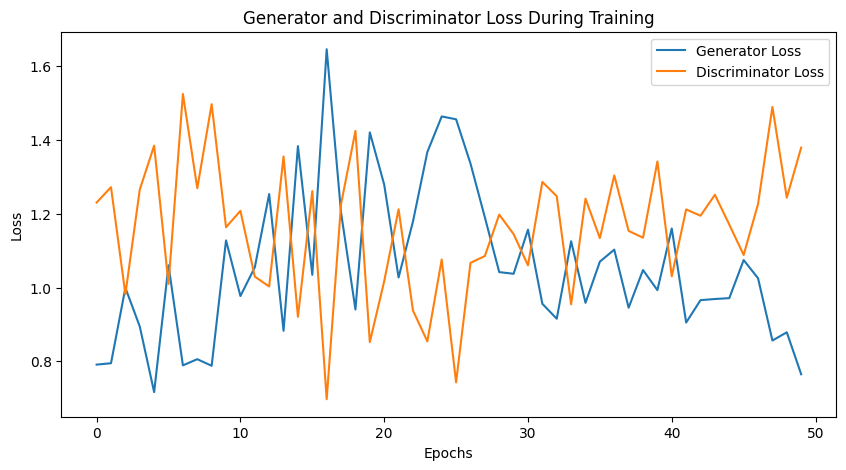

Minimum Generator Loss: 0.7165205478668213
Minimum Discriminator Loss: 0.697304368019104


In [78]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [79]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Creating a GIF


In [80]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

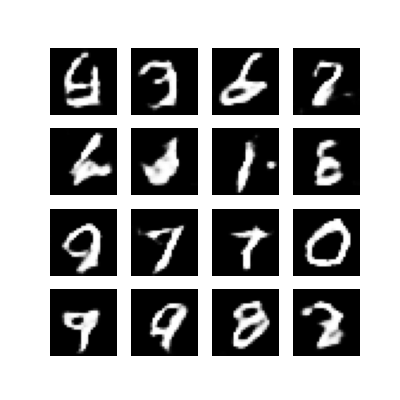

In [81]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [82]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-82-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-82-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [83]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-xoqrbn5_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-xoqrbn5_
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done



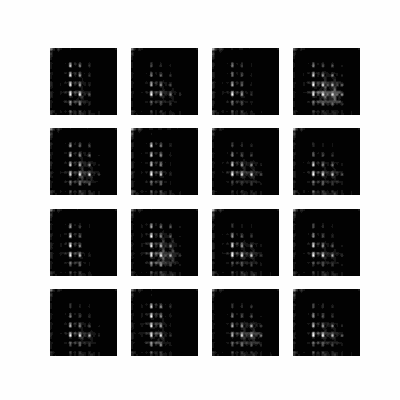

In [84]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

##Improving the model

Defining the new Generator and Discriminator

In [85]:
def make_generator_model_2():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_10 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 7, 7, 128)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_11 (Ba  (None, 7, 7, 128)        

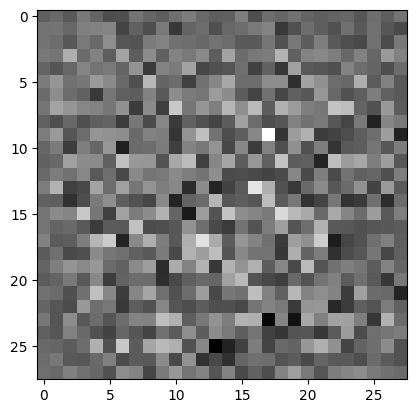

In [86]:
new_generator = make_generator_model_2()
new_generator.summary()

noise = tf.random.normal([1, 100])
new_generated_image = new_generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [87]:
def make_discriminator_model_2():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [88]:
new_discriminator = make_discriminator_model_2()
decision = new_discriminator(new_generated_image)
print (decision)
new_discriminator.summary()

tf.Tensor([[-0.00077103]], shape=(1, 1), dtype=float32)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       3328      
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 7, 7, 256)         0         
                                                                 
 dropout_8 (Dropout)         (None, 7, 7, 256)         0         
                                                                

In [89]:
new_generator_optimizer = tf.keras.optimizers.Adam(1e-4)
new_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
new_generator_optimizer.build(new_generator.trainable_variables)
new_discriminator_optimizer.build(new_discriminator.trainable_variables)

new checkpoints

In [90]:
checkpoint_dir = './training_checkpoints_2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer= new_generator_optimizer,
                                 discriminator_optimizer= new_discriminator_optimizer,
                                 generator= new_generator,
                                 discriminator= new_discriminator)

Changing the functions

In [91]:
@tf.function
def train_step_again(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = new_generator(noise, training=True)

      real_output = new_discriminator(images, training=True)
      fake_output = new_discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, new_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, new_discriminator.trainable_variables)

    new_generator_optimizer.apply_gradients(zip(gradients_of_generator, new_generator.trainable_variables))
    new_discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, new_discriminator.trainable_variables))
    return gen_loss, disc_loss

In [92]:
def generate_and_save_images_2(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('new_model_image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [93]:
def train_again(dataset, epochs):
  gen_losses = []
  disc_losses = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step_again(image_batch)

    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)

    #print(f'Epoch {epoch+1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')




    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images_2(new_generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images_2(new_generator,
                           epochs,
                           seed)

   # Plot the losses
  plt.figure(figsize=(10, 5))
  plt.plot(gen_losses, label='Generator Loss')
  plt.plot(disc_losses, label='Discriminator Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Generator and Discriminator Loss During Training')
  plt.show()

  # Print minimum errors observed
  print(f'Minimum Generator Loss: {min(gen_losses)}')
  print(f'Minimum Discriminator Loss: {min(disc_losses)}')

Training the model

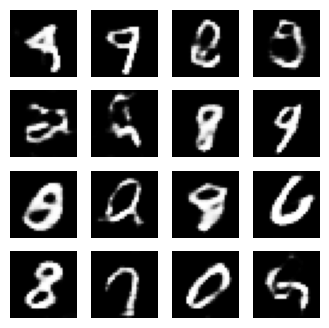

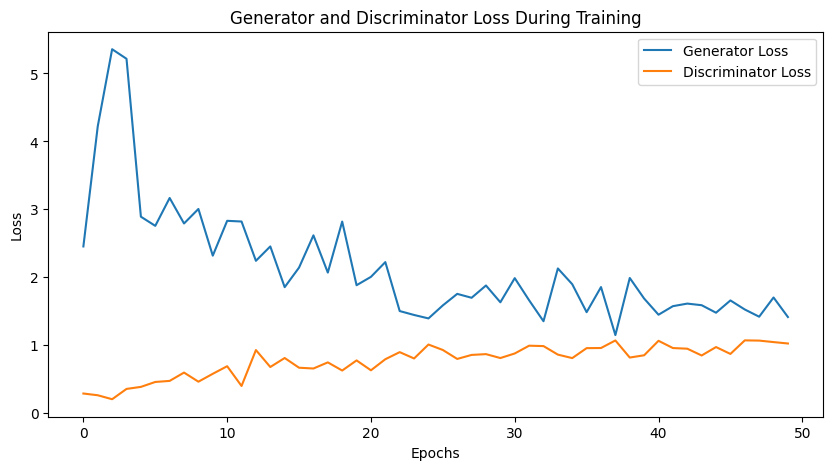

Minimum Generator Loss: 1.1488616466522217
Minimum Discriminator Loss: 0.20459893345832825


In [94]:
train_again(train_dataset, EPOCHS)

Displaying the image and creating GIF for the improved model

In [95]:
def display_image_2(epoch_no):
  return PIL.Image.open('new_model_image_at_epoch_{:04d}.png'.format(epoch_no))

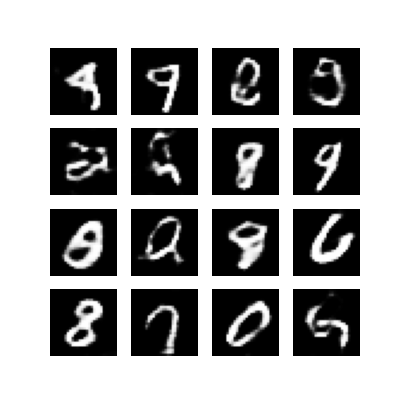

In [96]:
display_image_2(EPOCHS)

In [101]:
anim_file_2 = 'dcgan2.gif'

with imageio.get_writer(anim_file_2, mode='I') as writer:
  filenames = glob.glob('new_model*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-101-921dc1a49172>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-101-921dc1a49172>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



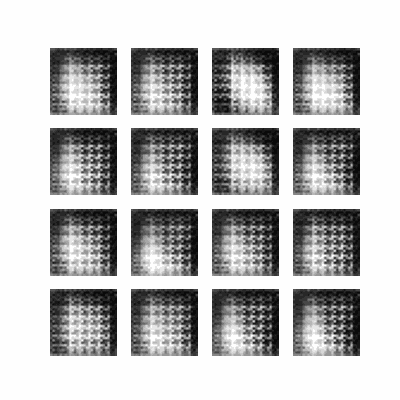

In [102]:
embed.embed_file(anim_file_2)

Comparing the images and the GIFs

Epoch 1


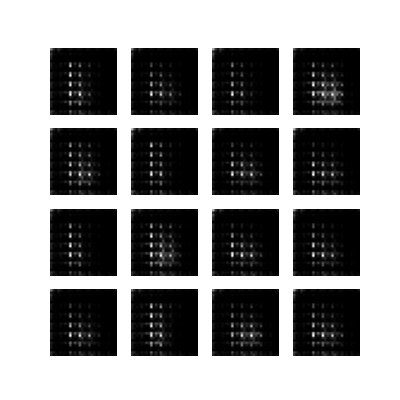

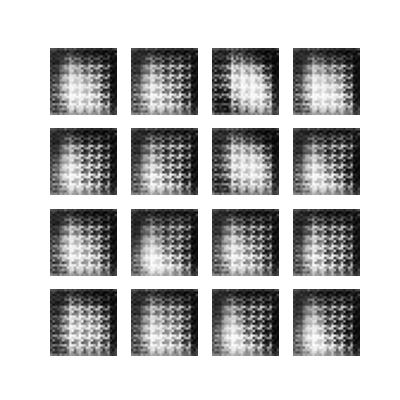



Epoch 11


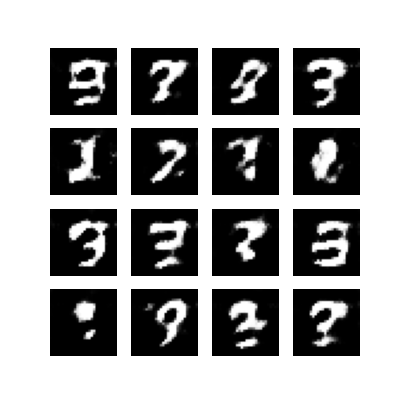

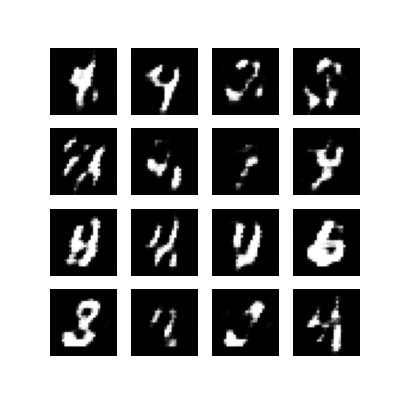



Epoch 21


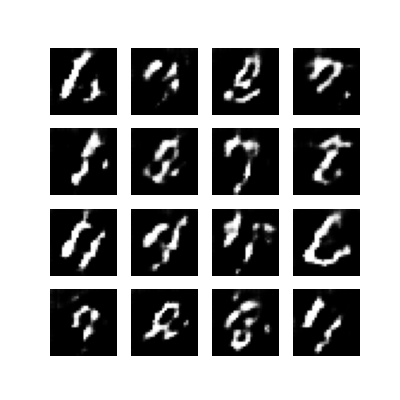

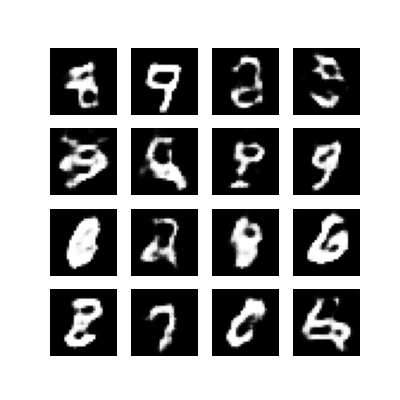



Epoch 31


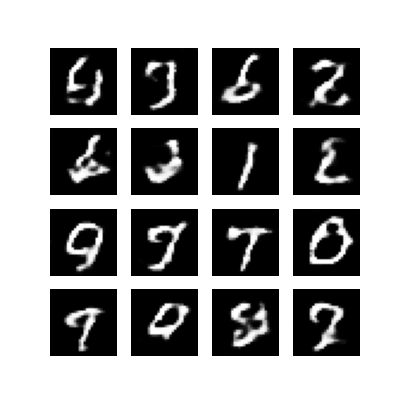

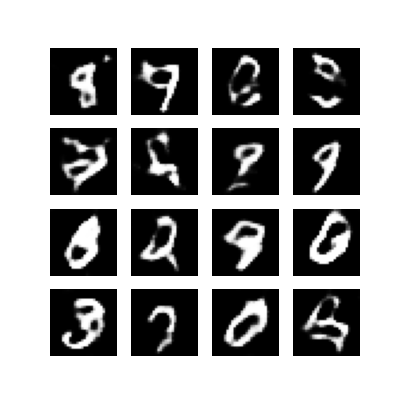



Epoch 41


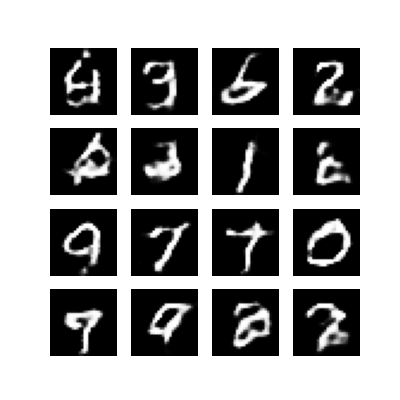

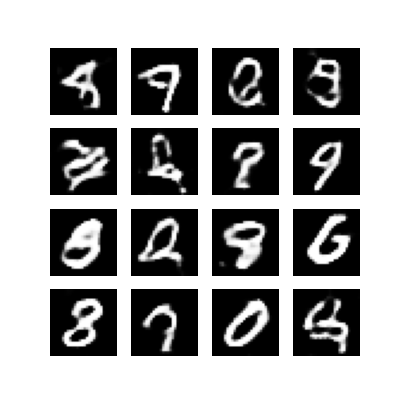



final images


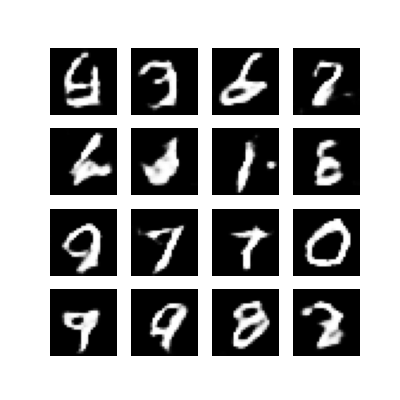

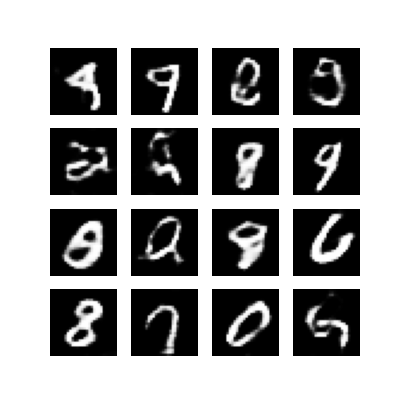

In [110]:
for i in range(1,50,10):
  print(f'Epoch {i}')
  display(display_image(i))
  display(display_image_2(i))
  print('\n')

print('final images')
display(display_image(EPOCHS))
display(display_image_2(EPOCHS))
print('\n')


The starting images are similar but the images get much better for the improved model. Same thing can be observed in the GIFs.